In [103]:
import numpy as np
import scipy as sp
from pathlib2 import Path


class Solver:
    def __init__(self, step=0.1):
        self.step = step
        self.ro_w = 1  # g/sm^3
        self.mu_g = 29  # g/mol
        self.mu_v = 18  # g/mol
        self.g = -9.8
        self.p0 = 10 ** 5  # Pa
        self.l = 2260  # Dj/g
        self.eta_g = 3 * 10 ** -5 # Pa * sec
        self.kappa_g = 0.02 # W/m K

        self.eta = 0
        self.kappa = 0
        self.xi_l = 0
        self.xi_v = 0

        self.c_v = 3 * 8.134 / 2 
        self.c_p = 5 * 8.134 / 2 
        self.c_vv = 3 * 8.134 / self.mu_v
        self.c_vg = (5 / 2) * 8.134 / self.mu_g
        self.c_l = 4183
        self.c_pg = 4 * 8.134 / self.mu_v
        self.c_pv = (7 / 2) * 8.134 / self.mu_g

        self.T0 = 0
        self.R0 = 0
        self.Q0 = 0
        self.h = 0

        self.v = 0
        self.r = 0
        self.t = 0
        self.ro_v = 0
        self.ro_l = 0
        self.ro_g = 0

        self.velocity = []
        self.radius = []
        self.temperature = []
        self.gas_density = []
        self.vap_density = []
        self.liq_density = []
        self.xi_l_hist = []
        self.xi_v_hist = []

    def set_initial_conditions(self, t=1, r=0, p=0, q=0, h=0):
        self.T0 = t
        self.R0 = r
        self.p0 = p
        self.Q0 = q
        self.h = h

        self.ro_g = (self.p0 + self.ro_w * self.g * h) * self.mu_g / (8.31 * t)
        self.v = q / (np.pi * self.R0 ** 2 * self.ro_g)
        self.ro_l = 0
        self.ro_v = 0
        self.t = t
        self.r = r

        self.iter_num = int(self.h / self.step)

        self.velocity.append(self.v)
        self.radius.append(self.r)
        self.temperature.append(self.t)
        self.gas_density.append(self.ro_g)
        self.vap_density.append(self.ro_v)
        self.liq_density.append(self.ro_g)

    def _get_xi(self, indx):
        self.eta = 0.5 * self.ro_g * self.v ** 2 * 0.027 * (self.ro_g * self.v * (indx * self.step) / self.eta_g) ** (-1/7)
        self.kappa = 10 ** 3 * 0.022  # 0.022 for air termoconductivity

        #self.xi_v = 2 * np.pi * self.kappa * self.tay(self.t - self._get_t_boiling(indx)) / self.l - \
        #            (2 * np.pi * self.eta * self.v ** 2) / (self.l * 2)
        #self.xi_l = 2 * np.pi * self.eta - self.xi_v
         
        A = np.array([[self.v, self.v],
                      [0.5 * self.v ** 2, 0.5 * self.v ** 2 + self.l]])

        b = np.array([2 * np.pi * self.eta * self.v * self.r / 8.314,
                      2 * np.pi * self.kappa * self.tay(self.t - self._get_t_boiling(indx)) * self.r / 8.314])

        self.xi_l, self.xi_v = np.linalg.solve(A, b)
        
        
        print("A:", A)
        print("b:", b)
        
        self.xi_l_hist.append(self.xi_l)
        self.xi_v_hist.append(self.xi_v)
        
        print('eta:', self.eta)
        print('kappa:', self.kappa)
        print("tay:", self.tay(self.t - self._get_t_boiling(indx)))
        print("T boiling:", self._get_t_boiling(indx))
        print("Xi_v:", self.xi_v)
        print("Xi_l:", self.xi_l)
        
        
        return [self.xi_v, self.xi_l]
        
        

    def _get_t_boiling(self, indx):
        e = 5
        return (self.p0 + self.ro_w * np.abs(self.g) * (self.h - indx * self.step)) / \
               (8.3145 * (self.ro_g/self.mu_g + self.ro_v/self.mu_v + e))

    def do_iteration(self, indx):
        self._get_xi(indx)
        
        A = np.array([[np.pi * self.ro_v * self.r ** 2, 2 * np.pi * self.ro_v * self.r, 0,
                       np.pi * self.v * self.r ** 2, 0, 0],
                      [np.pi * self.ro_l * self.r ** 2, 2 * np.pi * self.ro_l * self.r, 0,
                       0, np.pi * self.v * self.r ** 2, 0],
                      [2 * np.pi * self.r ** 2 * self._get_ro() * self.v, 2 * np.pi * self.r * self._get_ro() * self.v ** 2, 0,
                       np.pi * self.r ** 2 * self.v ** 2 * self.c_vv / self.c_v, np.pi * self.r ** 2 * self.v ** 2 * self.c_l / self.c_v,
                       np.pi * self.r ** 2 * self.v ** 2 * self.c_vg / self.c_v],
                      [np.pi * self.r ** 2 * self._get_ro() * self.g, 2 * np.pi * self.r * self.v * self.ro_g,
                       0, 0, 0, np.pi * self.r ** 2 * self.v],
                      [self.v, 0, self.c_p, 0, 0, 0],
                      [0, 0, 8.314 * (self.ro_g / self.mu_g + self.ro_v / self.mu_v), 8.314 * self.t / self.mu_v, 0, 8.314 * self.t / self.mu_g]
                    ])

        f = [self.xi_v, 
             self.xi_l, 
             np.pi * self.r ** 2 * self.g * (self.ro_w - self._get_ro()), 
             0,
             -self.g - ((self.l + self.c_pv * self.t)*self.xi_v + self.c_l * self.xi_l * self.t +
                        (self.xi_l + self.xi_v) * (0.5 * self.v ** 2 + self.g * indx * self.step))
             / (np.pi * self.r ** 2 * self._get_ro() * self.v), 
             -1 * self.ro_w * self.g]
        
        #print('A:', A)
        #print('f:', f)
        return np.linalg.solve(A, f)

    def make_time_iter(self):
        for indx in range(1, self.iter_num + 1):
            new_iteration = self.do_iteration(indx)

            self.v = self.v + new_iteration[0] * self.step
            self.r = self.r + new_iteration[1] * self.step
            self.t = self.t + new_iteration[2] * self.step
            self.ro_v = self.ro_v + new_iteration[3] * self.step
            self.ro_l = self.ro_l + new_iteration[4] * self.step
            self.ro_g = self.ro_g + new_iteration[5] * self.step

            self.velocity.append(self.v)
            self.radius.append(self.r)
            self.temperature.append(self.t)
            self.gas_density.append(self.ro_g)
            self.vap_density.append(self.ro_v)
            self.liq_density.append(self.ro_g)

    def _get_ro(self):
        return (self.ro_g * self.c_vg + self.c_vv * self.ro_v + self.c_l * self.ro_l) / self.c_v

    @staticmethod
    def theta(x):
        if x <= 0:
            return 0
        else:
            return 1

    @staticmethod
    def tay(x):
        if x >= 0:
            return x
        else:
            return 0


In [104]:
s = Solver(0.1)
s.set_initial_conditions(t=1000, r=10, p=10**5, q=300000, h=50)

s.make_time_iter()

A: [[   2.74984162    2.74984162]
 [   3.78081448 2263.78081448]]
b: [   86.7584476  47883.50655111]
eta: 4.17478623234879
kappa: 22.0
tay: 288.0006166552316
T boiling: 711.9993833447684
Xi_v: 21.134610865417923
Xi_l: 10.415732550157875
A: [[   2.85967882    2.85967882]
 [   4.08888148 2264.08888148]]
b: [   89.26527224 47085.48600916]
eta: 4.109708104794966
kappa: 22.0
tay: 281.77994414170405
T boiling: 705.8069666112101
Xi_v: 20.777810179170242
Xi_l: 10.437328941258146
A: [[   2.96623179    2.96623179]
 [   4.39926551 2264.39926551]]
b: [   94.91139697 46375.32990919]
eta: 4.191816161145421
kappa: 22.0
tay: 276.15523339139804
T boiling: 700.1154007434582
Xi_v: 20.457772260124795
Xi_l: 11.539523905586508
A: [[   3.06759483    3.06759483]
 [   4.70506902 2264.70506902]]
b: [  101.69456478 45611.88958199]
eta: 4.325154854839728
kappa: 22.0
tay: 270.4937906037869
T boiling: 694.3114467048457
Xi_v: 20.113234832459153
Xi_l: 13.038002664710314
A: [[   3.16357052    3.16357052]
 [   5.004089

b: [1807.52866522 1345.5803998 ]
eta: 45.36571190979415
kappa: 22.0
tay: 10.648225294788404
T boiling: 193.61039147461832
Xi_v: -2.1785339517428715
Xi_l: 262.7563685374686
A: [[   6.95694261    6.95694261]
 [  24.19952527 2284.19952527]]
b: [1833.50302947 1309.99471588]
eta: 45.93903727799321
kappa: 22.0
tay: 10.379239702687613
T boiling: 191.87392577575108
Xi_v: -2.2423862673542585
Xi_l: 265.7925017374744
A: [[   6.97715251    6.97715251]
 [  24.34032858 2284.34032858]]
b: [1859.68765342 1275.42661634]
eta: 46.51559668763853
kappa: 22.0
tay: 10.117415823544377
T boiling: 190.1620453809931
Xi_v: -2.3062989266938225
Xi_l: 268.845929585919
A: [[   6.99724817    6.99724817]
 [  24.48074098 2284.48074098]]
b: [1886.08308871 1241.84265173]
eta: 47.095378146282016
kappa: 22.0
tay: 9.862536775091627
T boiling: 188.47430740376316
Xi_v: -2.370288968853552
Xi_l: 271.9166938750288
A: [[   7.01723094    7.01723094]
 [  24.62076506 2284.62076506]]
b: [1912.68988778 1209.21062287]
eta: 47.6783695526

A: [[   8.21096425    8.21096425]
 [  33.70996695 2293.70996695]]
b: [4376.44928797  180.3662601 ]
eta: 96.39773686792843
kappa: 22.0
tay: 1.4827629246346277
T boiling: 110.29597383711365
Xi_v: -7.870384098209493
Xi_l: 540.8710347995883
A: [[   8.22528577    8.22528577]
 [  33.82766302 2293.82766302]]
b: [4419.71998042  175.00024257]
eta: 97.17309765626361
kappa: 22.0
tay: 1.4385277963004484
T boiling: 109.61753432623968
Xi_v: -7.965367121183877
Xi_l: 545.2986711216165
A: [[   8.23955241    8.23955241]
 [  33.94511195 2293.94511195]]
b: [4463.24146082  169.75181388]
eta: 97.95050432606153
kappa: 22.0
tay: 1.3952487976564782
T boiling: 108.94656383407855
Xi_v: -8.060975287887095
Xi_l: 549.7459163431047
A: [[   8.25376461    8.25376461]
 [  34.0623151  2294.0623151 ]]
b: [4507.01422541  164.61806966]
eta: 98.72993769986623
kappa: 22.0
tay: 1.3529035520209476
T boiling: 108.28295938873157
Xi_v: -8.157212027139233
Xi_l: 554.21279264885
A: [[   8.26792281    8.26792281]
 [  34.17927383 2294

T boiling: 70.91771785635724
Xi_v: -18.917579275440346
Xi_l: 1007.5247552655591
A: [[   9.31090759    9.31090759]
 [  43.34650005 2303.34650005]]
b: [9261.22160691    0.        ]
eta: 171.13475270947282
kappa: 22.0
tay: 0
T boiling: 70.63544302778257
Xi_v: -19.077517373239278
Xi_l: 1013.7411975906298
A: [[   9.32163176    9.32163176]
 [  43.44640937 2303.44640937]]
b: [9328.53145016    0.        ]
eta: 172.0128967207245
kappa: 22.0
tay: 0
T boiling: 70.35571596418981
Xi_v: -19.2383042195963
Xi_l: 1019.978484355785
A: [[   9.33232626    9.33232626]
 [  43.54615672 2303.54615672]]
b: [9396.12839314    0.        ]
eta: 172.89127134925297
kappa: 22.0
tay: 0
T boiling: 70.07850938125614
Xi_v: -19.39994153881367
Xi_l: 1026.2366219461214
A: [[   9.34299125    9.34299125]
 [  43.64574277 2303.64574277]]
b: [9464.01275146    0.        ]
eta: 173.76985659266964
kappa: 22.0
tay: 0
T boiling: 69.80379635711797
Xi_v: -19.562431050003863
Xi_l: 1032.515616615762
A: [[   9.35362691    9.35362691]
 [  

b: [17555.19272295     0.        ]
eta: 257.90899185603604
kappa: 22.0
tay: 0
T boiling: 51.73843437062559
Xi_v: -39.87871556100415
Xi_l: 1749.6247554024637
A: [[  10.27611627   10.27611627]
 [  52.7992828  2312.7992828 ]]
b: [17652.82940439     0.        ]
eta: 258.72028514696626
kappa: 22.0
tay: 0
T boiling: 51.61994133996019
Xi_v: -40.13330253616738
Xi_l: 1757.9836011946288
A: [[  10.28449522   10.28449522]
 [  52.885421   2312.885421  ]]
b: [17750.77771441     0.        ]
eta: 259.5301479436232
kappa: 22.0
tay: 0
T boiling: 51.50241229296818
Xi_v: -40.38889128652427
Xi_l: 1766.3635092778004
A: [[  10.29285642   10.29285642]
 [  52.97144663 2312.97144663]]
b: [17849.03784923     0.        ]
eta: 260.3385684446865
kappa: 22.0
tay: 0
T boiling: 51.385839139208635
Xi_v: -40.64548314261525
Xi_l: 1774.7644800594892
A: [[  10.30119994   10.30119994]
 [  53.05736006 2313.05736006]]
b: [17947.61000479     0.        ]
eta: 261.1455349517282
kappa: 22.0
tay: 0
T boiling: 51.27021387380098
Xi_

Xi_v: -69.78861276912517
Xi_l: 2669.1123258399293
A: [[  11.02314524   11.02314524]
 [  60.75486546 2320.75486546]]
b: [28763.75967329     0.        ]
eta: 329.8218069679327
kappa: 22.0
tay: 0
T boiling: 43.67437231262546
Xi_v: -70.14758859596935
Xi_l: 2679.544367254612
A: [[  11.03009103   11.03009103]
 [  60.83145411 2320.83145411]]
b: [28893.21406406     0.        ]
eta: 330.4501666316193
kappa: 22.0
tay: 0
T boiling: 43.62232128093716
Xi_v: -70.50769500042466
Xi_l: 2689.99777663625
A: [[  11.03702485   11.03702485]
 [  60.90795878 2320.90795878]]
b: [29023.00059068     0.        ]
eta: 331.07641272416345
kappa: 22.0
tay: 0
T boiling: 43.57072408919651
Xi_v: -70.86893335355894
Xi_l: 2700.472561465591
A: [[  11.04394673   11.04394673]
 [  60.98437969 2320.98437969]]
b: [29153.1194958     0.       ]
eta: 331.7005429461048
kappa: 22.0
tay: 0
T boiling: 43.51957763429515
Xi_v: -71.23130502898312
Xi_l: 2710.968729336857
A: [[  11.05085672   11.05085672]
 [  61.06071709 2321.06071709]]
b:

In [105]:
import matplotlib.pyplot as plt

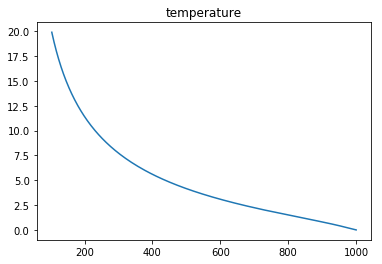

In [106]:
temp = s.temperature[:200]
plt.plot(temp, np.arange(0, 50, 0.1)[:200])
plt.title('temperature')
plt.show()

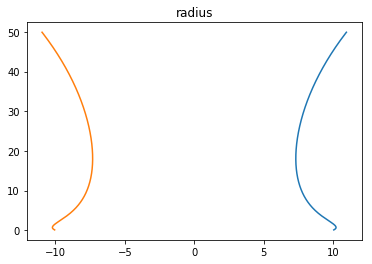

In [107]:
radius = s.radius[1:500]
plt.plot(radius, np.arange(0, s.h, s.step)[1:500])
plt.plot([-1 * x for x in radius], np.arange(0, s.h, s.step)[1:500])
plt.title('radius')
plt.show()

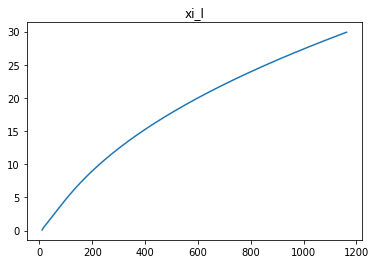

In [108]:
radius = s.xi_l_hist[1:300]
plt.plot(radius, np.arange(0, s.h, s.step)[1:300])
plt.title('xi_l')
plt.show()

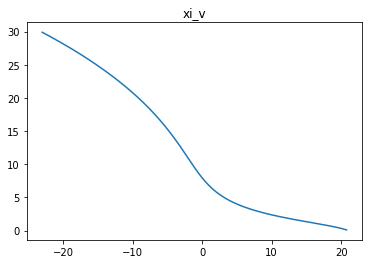

In [109]:
radius = s.xi_v_hist[1:300]
plt.plot(radius, np.arange(0, s.h, s.step)[1:300])
plt.title('xi_v')
plt.show()